## TensorFlow model generation

This is a regular notebook structure - run each cell in order

In [1]:
import tensorflow as tf
import pickle
import numpy as np

from shared_project_functions import get_target_subdirectory

/Users/jare/Library/CloudStorage/GoogleDrive-johnallan.e@gmail.com/Other computers/My MacBook Pro/Applied AI Solutions/4011 - Math for DL 1/Project/.venv-metal/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Preprocessed data loading

Provide model name - must be the same as what you used in preprocessing step

In [2]:
base_corpus = "doyle"

dir = get_target_subdirectory(base_corpus, subdir_string="model")

#Load preprocessed data from subdirectory
with open(f"{dir}/{base_corpus}_preprocessed_data.pkl", "rb") as f:
    data = pickle.load(f)
    X_train = data["X_train"]
    y_train = data["y_train"]
    word_to_id = data["word_to_id"]
    id_to_word = data["id_to_word"],
    max_seq_length = data["max_seq_length"]

In [3]:
# Model hyperparameters
vocab_size = len(word_to_id)
embedding_dim = 200  # The size of the word vectors
rnn_units = 1024     # The number of units in the LSTM layer
dropout = 0.2        # Dropout rate for regularization

In [4]:
def load_glove_embeddings(glove_path, word_to_id, embedding_dim):
    """
    Loads GloVe embeddings and creates an embedding matrix for your vocabulary.

    Args:
        glove_path (str): Path to the GloVe .txt file.
        word_to_id (dict): Mapping from word to integer ID.
        embedding_dim (int): Dimension of the GloVe vectors.

    Returns:
        np.ndarray: Embedding matrix of shape (vocab_size, embedding_dim).
    """
    # Initialize embedding matrix with random values
    vocab_size = len(word_to_id)
    embedding_matrix = np.random.normal(size=(vocab_size, embedding_dim))

    # Load GloVe vectors
    print(f"Loading GloVe vectors from {glove_path} ...")
    glove = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove[word] = vector

    # Fill embedding matrix
    found = 0
    for word, idx in word_to_id.items():
        vector = glove.get(word)
        if vector is not None and vector.shape[0] == embedding_dim:
            embedding_matrix[idx] = vector
            found += 1
    print(f"Found {found} out of {vocab_size} words in GloVe.")

    return embedding_matrix

In [5]:
#Download glove embeddings
#2.25GB download
#!curl -O http://nlp.stanford.edu/data/glove.6B.zip #wget on PC, curl on Mac
#!unzip -o glove.6B.zip

In [12]:
# Optional - word2vec or GloVe embeddings

using_pretrained_embeddings = True
    #True: Use pre-trained embeddings (GloVe)
    #False: Use randomly initialized embeddings

if using_pretrained_embeddings:
    embedding_dim = 300  # Must match the GloVe vector dimension
    glove_path = f"glove.6B.{embedding_dim}d.txt"  # Update with your GloVe file path
    embedding_matrix = load_glove_embeddings(glove_path, word_to_id, embedding_dim)
    #Save embedding matrix for future use
    np.save(f"{dir}/{base_corpus}_embedding_matrix.npy", embedding_matrix)
    print(f"Saved embedding matrix to {dir}/{base_corpus}_embedding_matrix.npy")

Loading GloVe vectors from glove.6B.300d.txt ...
Found 33721 out of 38177 words in GloVe.
Saved embedding matrix to model_2_doyle/doyle_embedding_matrix.npy


In [ ]:
if using_pretrained_embeddings:
    #print some random embeddings values to verify loading
    print("Sample embeddings from the embedding matrix:")
    for i in range(5):
        random_idx = np.random.randint(0, vocab_size)
        print(f"Embedding: {embedding_matrix[random_idx][:5]}...")  # Print first 5 values

Sample embeddings from the embedding matrix:
Embedding: [ 0.024516    0.35032001  0.30351999  0.14568    -0.41692001]...
Embedding: [-0.77842999 -0.41328001 -0.52430999 -0.57077998 -0.25095999]...
Embedding: [-0.15716    -0.062767   -0.21735001  0.41406    -0.31815001]...
Embedding: [-0.19774    -0.67842001  0.019021   -0.37331     0.51286   ]...
Embedding: [-0.42182001  0.065931    0.15132     0.0091872   0.016615  ]...


In [ ]:
# Define model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Load the embedding matrix if using pre-trained embeddings
if using_pretrained_embeddings:
    embedding_matrix = np.load(f"{dir}/{base_corpus}_embedding_matrix.npy")

# Define the embedding layer based on the flag
if using_pretrained_embeddings:
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_seq_length,
        weights=[embedding_matrix],
        trainable=False
    )
    
else:
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_seq_length
    )

# Build the model
model = Sequential([
    embedding_layer,
    LSTM(rnn_units, return_sequences=True),
    Dropout(dropout),
    LSTM(rnn_units),
    Dropout(dropout),
    Dense(vocab_size, activation='softmax')
])

/Users/jare/Library/CloudStorage/GoogleDrive-johnallan.e@gmail.com/Other computers/My MacBook Pro/Applied AI Solutions/4011 - Math for DL 1/Project/.venv-metal/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-09-19 11:54:28.656291: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-09-19 11:54:28.656507: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-19 11:54:28.656527: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-09-19 11:54:28.656811: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-19 11:54:28.656834: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/

In [9]:
# Compile model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Print a summary of model to see layers and parameter count
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    11,453,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,453,100 (43.69 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 11,453,100 (43.69 MB)

In [10]:
# Convert training lists to numpy arrays
x_train_np = np.array(X_train)
y_train_np = np.array(y_train)

# Train the model and save the training history
history = model.fit(
    x_train_np,
    y_train_np,
    epochs=10,
    batch_size=128
)

# Save the trained model
model.save(f"{dir}/[{base_corpus}_model.keras")

#Save the training history to subdirectory
with open(f"{dir}/{base_corpus}_training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

Epoch 1/10


2025-09-19 11:54:31.409188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


   28/28693 ━━━━━━━━━━━━━━━━━━━━ 1:32:53 194ms/step - accuracy: 0.0468 - loss: 8.7859

KeyboardInterrupt: 

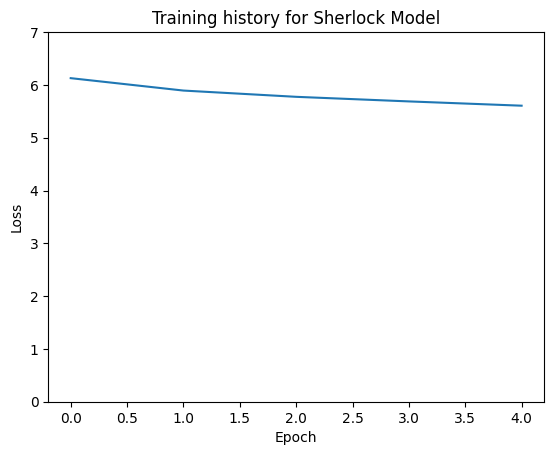

In [ ]:
#display history
import matplotlib.pyplot as plt

#load history file from subdirectory
with open(f"{dir}/{base_corpus}_training_history.pkl", "rb") as f:
    history = pickle.load(f)
    
#Y-axis limit for loss plot
plt.ylim(0, np.ceil(max(history['loss'])))

#Tile and labels
plt.title(f'Training history for {base_corpus.capitalize()} Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history['loss'], label='loss')